# Notebook Instructions

1. All the <u>code and data files</u> used in this course are available in the downloadable unit of the <u>last section of this course</u>.
2. You can run the notebook document sequentially (one cell at a time) by pressing **Shift + Enter**. 
3. While a cell is running, a [*] is shown on the left. After the cell is run, the output will appear on the next line.

This course is based on specific versions of python packages. You can find the details of the packages in <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank" >this manual</a>.

# Strategy Backtesting

So far you have seen different model evaluation metrics like accuracy, precision, recall and f1-score. After you are satisfied with the model performance, you can take the signals generated by them to trade and analyse the returns. Not only returns, but you should also analyse the risk associated with generating the returns.

In this notebook, you will perform the following steps:

1. [Read the Data](#read)<br>
2. [Calculate Strategy Returns](#strategy-returns)<br>
3. [Plot the Equity Curve](#equity-curve)<br>
4. [Performance Metrics ](#performance-metrics)<br>
    4.1. [Annualised Returns](#annualised-returns)<br>
    4.2. [Annualised Volatility](#annualised-volatility)<br>
    4.3. [Maximum Drawdown](#max-dd)<br>
    4.4. [Sharpe Ratio](#sharpe)<br>
    
## Import Libraries


In [1]:
# For data manipulation
import numpy as np
import pandas as pd

# For plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

<a id='read'></a> 
## Read the Data

In the previous section, you have used a random forest classifier to generate the signal whether to buy J.P. Morgan's stock or not. The signals are stored in a CSV `JPM_predicted_2019.csv`. Use the `read_csv` method of `pandas` to read this CSV and store it in a dataframe `strategy_data`. 

Also, read the close price of J.P. Morgan. This is stored in a column `close` in the CSV file `JPM_2017_2019.csv`. Store it in `close` column in `strategy_data`. While reading the close price data, slice the period to match the signal data. 

In [2]:
# The data is stored in the directory 'data_modules'
path = '../data_modules/'

# Read the CSV file using read_csv method of pandas
strategy_data = pd.read_csv(path + "JPM_predicted_2017_2019.csv", index_col=0)

# Read the close price
strategy_data['close'] = pd.read_csv(
    path + "JPM_2017_2019.csv", index_col=0).loc[strategy_data.index[0]:]['close']
strategy_data.index = pd.to_datetime(strategy_data.index)

# Preview the strategy data
strategy_data.head()

,signal,close
2019-05-28 12:00:00+00:00,0,109.29
2019-05-28 12:15:00+00:00,0,109.37
2019-05-28 12:30:00+00:00,1,109.33
2019-05-28 12:45:00+00:00,0,109.37
2019-05-28 13:00:00+00:00,0,109.38


<a id='strategy-returns'></a> 
## Calculate Strategy Returns

In [3]:
# Calculate the percentage change
strategy_data['pct_change'] = strategy_data['close'].pct_change()

# Calculate the strategy returns
strategy_data['strategy_returns'] = strategy_data['signal'].shift(1) * \
    strategy_data['pct_change']

# Drop the missing values
strategy_data.dropna(inplace=True)

strategy_data.head()

,signal,close,pct_change,strategy_returns
2019-05-28 12:15:00+00:00,0,109.37,0.000732,0.000000
2019-05-28 12:30:00+00:00,1,109.33,-0.000366,-0.000000
2019-05-28 12:45:00+00:00,0,109.37,0.000366,0.000366
2019-05-28 13:00:00+00:00,0,109.38,0.000091,0.000000
2019-05-28 13:15:00+00:00,0,109.37,-0.000091,-0.000000


<a id='equity-curve'></a> 
## Plot the Equity Curve

You can use an equity curve to visualise how the portfolio value has changed over a period of time. Plot the `cumulative_returns` columns of the `strategy_data` to check the same.

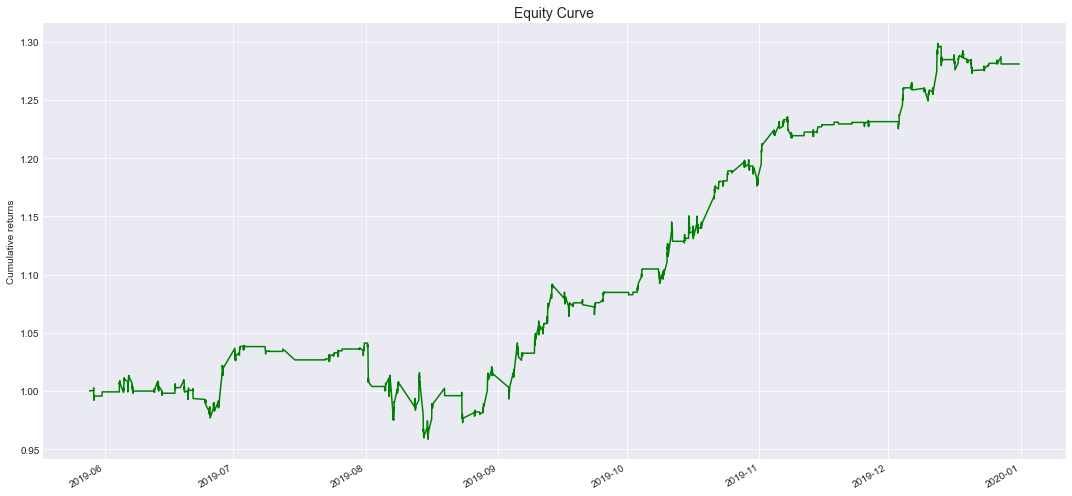

The cumulative return is 28.10%.


In [4]:
# Calculate the cumulative returns
strategy_data['cumulative_returns'] = (
    1+strategy_data['strategy_returns']).cumprod()

# ---------------------Equity Curve---------------------
# Plot cumulative strategy returns
strategy_data['cumulative_returns'].plot(figsize=(15, 7), color='green')
plt.title('Equity Curve', fontsize=14)
plt.ylabel('Cumulative returns')
plt.tight_layout()
plt.show()

cumulative_returns = (strategy_data['cumulative_returns'][-1] - 1)*100
print("The cumulative return is {0:.2f}%.".format(cumulative_returns))

From the above output, you can see that the strategy generated a cumulative returns of 28.10% in seven months.

<a id='performance-metrics'></a> 
## Performance Metrics

You can analyse the returns generated by the strategy and the risk associated with them using different performance metrics.

<a id='annualised-returns'></a>
**Annualised returns:** It is the average annual return of a strategy. It is calculated as below

$$ Annualised~Returns = (Cumulative~Returns^\frac{252*6.5*4}{no.~of~days}) - 1 $$


There are 252 trading days in a year, and 6.5 trading hours in a day. Since we are working with 15-minute data, the number of trading frequencies in a year is $252*6.5*4$. And the numerator in the exponent term is $252*6.5*4$.

In [5]:
# Calculate the annualised returns
annualised_return = ((strategy_data['cumulative_returns'][-1]) **
                    (252*6.5*4/strategy_data.shape[0]) - 1) * 100
print("The annualised return is {0:.2f}%.".format(annualised_return))

The annualised return is 52.20%.


From the above output, you can see that the average annual return of the strategy is 52.20%.

<a id='annualised-volatility'></a>
**Annualised volatility:** Annualised volatility is a measure of change in the price over a year. It is calculated as below.

$$ \text{Annualised Volatility} = \sqrt{\text{Var(Returns)}}*\sqrt{252*6.5*4}$$

In [6]:
# Calculate the annualised volatility
annualised_volatility = strategy_data['strategy_returns'].std()*np.sqrt(
    252*6.5*4) * 100
print("The annualised volatility is {0:.2f}%.".format(annualised_volatility))

The annualised volatility is 14.90%.


Annualised volatility of 14.90% means that for approximately 68% time in a year, the current time's price would differ by less than 14.90% from the previous time.

<a id='max-dd'></a>
**Maximum drawdown:** Maximum drawdown is the maximum value a portfolio lost from its peak. It is the maximum loss the strategy can make. Higher the value of the drawdown, higher would be the losses. It is calculated as below.

$$ Max.~Drawdown = \frac{Trough~Value-Peak~Value}{Peak~Value} $$

The maximum drawdown is -7.94%.


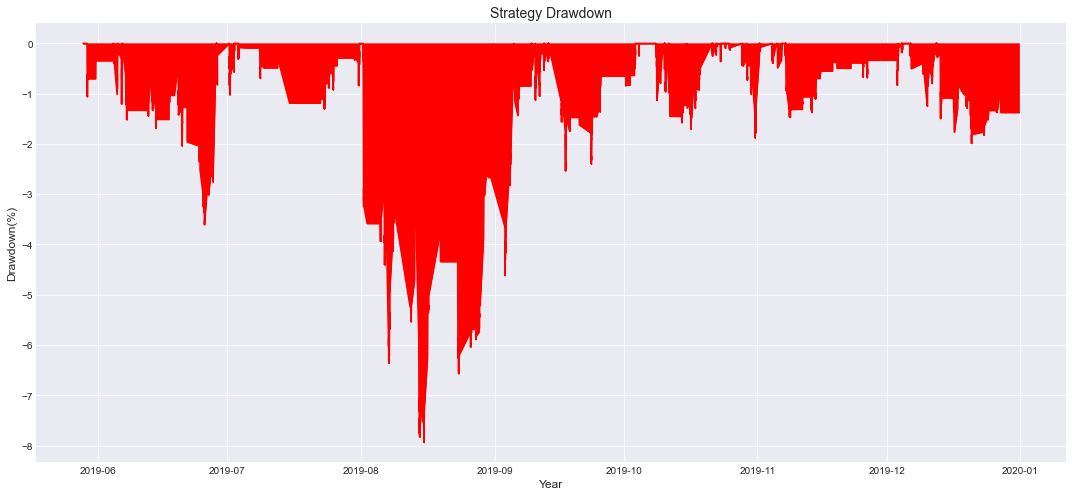

In [7]:
# Calculate the running maximum
running_max = np.maximum.accumulate(
    strategy_data['cumulative_returns'].dropna())
# Ensure the value never drops below 1
running_max[running_max < 1] = 1
# Calculate the percentage drawdown
drawdown = ((strategy_data['cumulative_returns'])/running_max - 1) * 100

# Calculate the maximum drawdown
max_dd = drawdown.min()
print("The maximum drawdown is {0:.2f}%.".format(max_dd))

# ---------------------DD plot---------------------
fig = plt.figure(figsize=(15, 7))

# Plot max drawdown
plt.plot(drawdown, color='red')
# Fill in-between the drawdown
plt.fill_between(drawdown.index, drawdown.values, color='red')
plt.title('Strategy Drawdown', fontsize=14)
plt.ylabel('Drawdown(%)', fontsize=12)
plt.xlabel('Year', fontsize=12)

plt.tight_layout()
plt.show()

From the above output, you can see that the maximum drawdown is 7.94%. This means that the maximum value that the portfolio lost from its peak was 7.94%.

<a id='sharpe'></a>
**Sharpe ratio:** Sharpe ratio measures the performance of a portfolio when compared to a risk-free asset. It is the ratio of the returns earned in excess of the risk-free rate to the volatility of the returns. It is calculated as below.

$$ Sharpe~ratio = \frac{R_p-R_f}{\sigma_p}$$

where
* $R_p$ is the return of the portfolio
* $R_f$ is the risk-free rate
* $\sigma_p$ is the volatility

A portfolio with a higher Sharpe ratio will be preferred over a portfolio with a lower Sharpe ratio.

In [8]:
# Calculate the Sharpe ratio
sharpe_ratio = round(strategy_data['strategy_returns'].mean() /
                     strategy_data['strategy_returns'].std() * np.sqrt(252*6.5*4), 2)
print("The Sharpe ratio is {0:.2f}.".format(sharpe_ratio))

The Sharpe ratio is 2.89.


The Sharpe ratio of 2.89 indicates that the returns are pretty good when compared to the risk associated.

**Note:** To keep the notebook simple, the transaction cost and slippage were not considered while analysing the performance of the strategy.

## Conclusion

You have learnt how to analyse the strategy and the cumulative returns of the strategy. You have also analysed the performance of a strategy on the historical data using different return and risk metrics. In the upcoming coding exercises, you will practice these techniques.<br><br>